In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn.linear_model import Ridge
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score

In [10]:
data = pd.read_csv("wdbc (5).data")
data = data.iloc[:,1:12]

Regularization of data such that each column has a mean of 0 and standard deviation of 1

In [11]:
for column in data.columns[1:]:
    mean = np.mean(data[column])
    std = np.std(data[column])
    data[column] = (data[column] - mean) / std

Binarize the Diagnosis Variable

In [12]:
data.loc[data["Diagnosis"] == 'M', "Diagnosis"] = 1
data.loc[data["Diagnosis"] == 'B', "Diagnosis"] = 0

In [20]:
import sklearn.metrics.cluster as cluster_metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model
from matplotlib.pyplot import contourf
from matplotlib import cm

def rlr_validate(X,y,lambdas,cvf=10):
    ''' Validate regularized linear regression model using 'cvf'-fold cross validation.
        Find the optimal lambda (minimizing validation error) from 'lambdas' list.
        The loss function computed as mean squared error on validation set (MSE).
        Function returns: MSE averaged over 'cvf' folds, optimal value of lambda,
        average weight values for all lambdas, MSE train&validation errors for all lambdas.
        The cross validation splits are standardized based on the mean and standard
        deviation of the training set when estimating the regularization strength.
        
        Parameters:
        X       training data set
        y       vector of values
        lambdas vector of lambda values to be validated
        cvf     number of crossvalidation folds     
        
        Returns:
        opt_val_err         validation error for optimum lambda
        opt_lambda          value of optimal lambda
        mean_w_vs_lambda    weights as function of lambda (matrix)
        train_err_vs_lambda train error as function of lambda (vector)
        test_err_vs_lambda  test error as function of lambda (vector)
    '''
    CV = model_selection.KFold(cvf, shuffle=True)
    M = X.shape[1]
    w = np.empty((M,cvf,len(lambdas)))
    train_error = np.empty((cvf,len(lambdas)))
    test_error = np.empty((cvf,len(lambdas)))
    f = 0
    y = y.squeeze()
    for train_index, test_index in CV.split(X,y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        # precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train
        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            lambdaI = lambdas[l] * np.eye(M)
            lambdaI[0,0] = 0 
            # remove bias regularization
            place_holder = XtX+lambdaI
            w[:,f,l] = np.linalg.solve(place_holder.astype(np.float),Xty.astype(np.float)).squeeze()
            # Evaluate training and test performance
            train_error[f,l] = np.power(y_train-X_train @ w[:,f,l].T,2).mean(axis=0)
            test_error[f,l] = np.power(y_test-X_test @ w[:,f,l].T,2).mean(axis=0)
    
        f=f+1

    opt_val_err = np.min(np.mean(test_error,axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error,axis=0))]
    train_err_vs_lambda = np.mean(train_error,axis=0)
    test_err_vs_lambda = np.mean(test_error,axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    
    return opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda

Regression Setup

Try again

C:\Users\birdl\AppData\Local\Temp\ipykernel_28988\290691948.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w[:,f,l] = np.linalg.solve(place_holder.astype(np.float),Xty.astype(np.float)).squeeze()
C:\Users\birdl\AppData\Local\Temp\ipykernel_28988\69023626.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_rlr[:,k] = np.linalg.sol

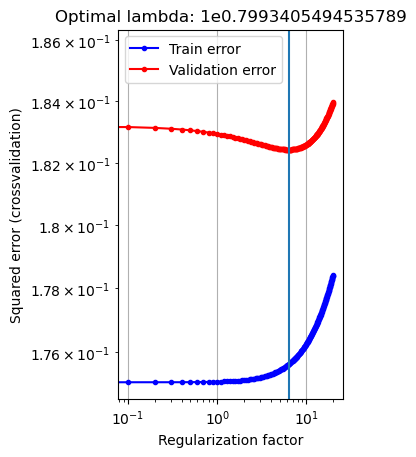

Weights in last fold:
         Offset            0.03
      Diagnosis           -0.06
     smoothness            0.28
      concavity            0.67
 concave points            0.06
        texture            0.02


In [37]:
X = data[['Diagnosis','smoothness','concavity','concave points', 'texture']].to_numpy()
y = data['compactness'].to_numpy()

attributeNames = ['Diagnosis','smoothness','concavity','concave points', 'texture']
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.arange(-5,20,0.1)

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term

    place_holder2 = (XtX+lambdaI)
    w_rlr[:,k] = np.linalg.solve(place_holder2.astype(np.float),Xty.astype(np.float)).squeeze()

    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        plt.axvline(x=opt_lambda)
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

show()

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))

Introduce a regularization parameter λ

Estimate the generalization error for different values of λ, for each value use K = 10 fold
cross-validation to estimate the generalization error

A figure of the estimated generalization error as a function of λ in the
report

Explain how a new data observation is predicted according to the linear model
with the lowest generalization error as estimated in the previous question. I.e.,
what are the effects of the selected attributes in terms of determining the
predicted class. Does the result make sense?